In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC  # Switched to LinearSVC

# Things that belong to strongly predictions, we just remove this
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']

# Define nominal and binary columns
# numeric is calculated using above 2.
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

def define_numeric_column(data: pd.DataFrame):
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]

def print_score():
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"SIMPLE LINEAR SVM CLASSIFIER")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=np.unique(y), columns=np.unique(y)))

def check_fitting():
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:
        print("Possible Overfitting.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:
        print("Possible Underfitting.")
    else:
        print("Good Fit.")

def preprocess_data(data: pd.DataFrame) -> tuple:
    data = data.copy()
    data['su_attempted'] = data['su_attempted'].replace({2: 0})
    numeric = define_numeric_column(data)
    return data[nominal + numeric + binary], data['attack_category']

def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

# Load and preprocess
df = pd.read_csv('kdd_merged.csv')
X, y = preprocess_data(df)
label_encode_nominal_data(X)

# Scale numeric features
numeric_cols = define_numeric_column(df)
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pre-select features, enough of time wasted on SVN
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# GridSearchCV with LinearSVC - cause normal thing was taking a lot of time!
dt_model = LinearSVC(random_state=42, tol=1e-3, max_iter=1000)
param_grid = {'C': [1, 10], 'class_weight': [None, 'balanced']}
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Train
start_time = time.time()
grid_search.fit(X_train_selected, y_train)
training_time = time.time() - start_time

# Best model
best_dt_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)
print(f"Hyperparameter Tuning Time: {training_time:.4f} seconds")

# Predict
y_train_pred = best_dt_model.predict(X_train_selected)
y_test_pred = best_dt_model.predict(X_test_selected)

# Evaluate
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print_score()
check_fitting()

# # Save model weights and data
# model_data = {
#     'coef_': best_dt_model.coef_,
#     'intercept_': best_dt_model.intercept_,
#     'classes_': best_dt_model.classes_,
#     'selected_features': X_train.columns[selector.get_support()].tolist(),
#     'X_test_selected': X_test_selected,
#     'y_test': y_test
# }
# joblib.dump(model_data, 'linear_svc_model_data.pkl')
# print("Model weights and data saved to 'linear_svc_model_data.pkl'")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  1.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.1min finished
/opt/python/3.7/anaconda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Best Hyperparameters: {'C': 1}
Hyperparameter Tuning Time: 182.8910 seconds
SIMPLE LINEAR SVM CLASSIFIER

Classification Report:
               precision    recall  f1-score   support

      benign       0.93      0.85      0.89     15411
         dos       0.95      0.91      0.93     10713
       probe       0.61      0.95      0.74      2816
         r2l       0.26      0.32      0.29       714
         u2r       0.00      0.00      0.00        50

    accuracy                           0.87     29704
   macro avg       0.55      0.61      0.57     29704
weighted avg       0.89      0.87      0.87     29704

Training Time: 182.8910 seconds
Training Accuracy: 0.8647
Testing Accuracy: 0.8696
Precision (Weighted): 0.8893
Recall (Weighted): 0.8696
F1-Score (Weighted): 0.8747

Confusion Matrix:
         benign   dos  probe  r2l  u2r
benign   13116   386   1336  572    1
dos        546  9800    323   44    0
probe       47    63   2686   20    0
r2l        406    22     58  228    0
u2r 

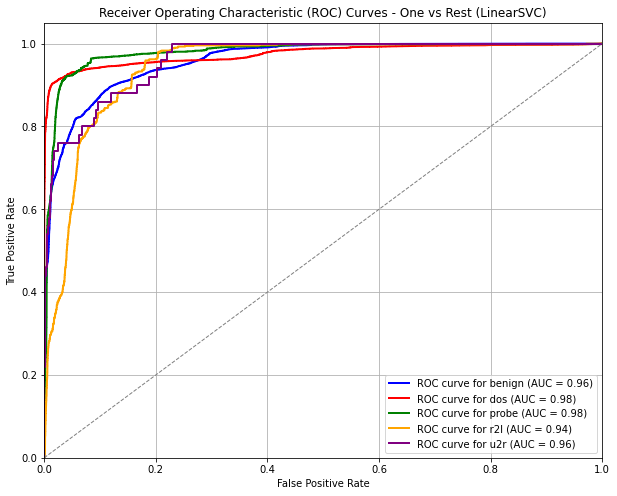


ROC AUC Scores for Each Class:
benign: 0.9593
dos: 0.9752
probe: 0.9794
r2l: 0.9446
u2r: 0.9616


In [3]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def plot_roc_curve():
    # Get unique classes
    classes = np.unique(y_test)
    n_classes = len(classes)

    # Binarize the test labels
    y_test_bin = label_binarize(y_test, classes=classes)

    # Get decision function scores for the test set (LinearSVC uses decision_function)
    y_test_score = best_dt_model.decision_function(X_test_selected)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()  # False Positive Rate
    tpr = dict()  # True Positive Rate
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust based on number of classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot diagonal line (random guessing)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves - One vs Rest (LinearSVC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Print AUC scores for each class
    print("\nROC AUC Scores for Each Class:")
    for i in range(n_classes):
        print(f"{classes[i]}: {roc_auc[i]:.4f}")
plot_roc_curve()